**Initialization**
- *obs. gitpython and pyvis packages installed in SA anaconda environment*
- Cloning Zeeguu-API

In [1]:
# For new environement, install the following packages
# install GitPython, and installs pyvis using the system's Python executable.
#gitpyhon is used to interact with git repositories, and pyvis is used to visualize the graph.
import sys
sys.version
!{sys.executable} -m pip install gitpython
!{sys.executable} -m pip install pyvis
!{sys.executable} -m pip install ast
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy

  Using cached AST-0.0.2.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\carl9\AppData\Local\Temp\pip-install-1tdiwwwp\ast_ea51705356a743e284c437a758190b07\setup.py", line 6, in <module>
          README = codecs.open(os.path.join(here, 'AST/README'), encoding='utf8').read()
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "<frozen codecs>", line 918, in open
      FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\carl9\\AppData\\Local\\Temp\\pip-install-1tdiwwwp\\ast_ea51705356a743e284c437a758190b07\\AST/README'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generati

In [2]:
from git import Repo
import os
import ast

# GitPython is a library that allows us to work easily with git from Python
# https://gitpython.readthedocs.io/en/stable/tutorial.html

# Let's declare a var for the path where we're going to download a repository
# Warning: this must end in /
CODE_ROOT_FOLDER="C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/"

# If the file exists, it means we've already downloaded
if not os.path.exists(CODE_ROOT_FOLDER):
  Repo.clone_from("https://github.com/zeeguu/api", CODE_ROOT_FOLDER)

**Helper Functions**

- **module_name_from_file_path()**  - *Extracts module from file path (.py files) e.g. ../core/model/user.py -> zeeguu.core.model.user*
- **get_all_files_in_repo()** - *returns list of all .py file paths from root folder*

In [3]:
# extracting a module name from a file name
#Ahh in windows we use \ instead of /, so we need to replace that as well... 
def module_name_from_file_path(full_path):
    file_name = full_path[len(CODE_ROOT_FOLDER):]
    file_name = file_name.replace("/__init__.py","")
    file_name = file_name.replace("\\__init__.py","")
    file_name = file_name.replace("/",".")
    file_name = file_name.replace("\\",".")
    file_name = file_name.replace(".py","")
    return file_name

# All .py files in root folder
def get_all_files_in_repo(repo_path):
    all_files = []
    for root, dirs, files in os.walk(repo_path):
        for file in files:
            if file.endswith(".py"):
                all_files.append(os.path.join(root, file))
    return all_files

**Data Gathering**

Utilize a defined grammar to parse and extract dependencies efficiently. Employ Abstract Syntax Trees (AST) to overcome the limitations posed by regex-based methods. This includes:
1. Parse a file and generate AST (read file, then use ast package to generate AST from content)
2. Define the grammar rules for the dependency extraction
3. Traverse AST and collect dependencies based on grammar
4. *define abstractions on different kinds of AST nodes*
5. store dependencies, make em' ready for visualization!

In [4]:

# Parse a Python file and return an AST. e.g. parse_file('example.py')
def file_to_ast_parser(f_path):
    with open(f_path, 'r') as file:
        code = file.read()
    return ast.parse(code, filename=f_path)

# Define "Grammar" rules for AST traversal of a single file
# could also do some counting here for more advanced analysis  / metric aggregati
#add current_dir to make up for relative paths
def collect_dependencies(abstract_syntax_tree, current_dir=""):
    dependencies = set()
    module_attributes = dict()
    used_dependencies = set()

    #Define node types/grammar rules for the AST traversal:
    def visit_Import(node):
        for alias in node.names:
            #collect the module names from the import statements (also handles the case of "import os" and "import os as cool_os alias" woop)
            dependencies.add(alias.asname if alias.asname else alias.name)

    def visit_ImportFrom(node):
        if node.module:
            if node.level > 0:  # Check if it's a relative import (we still want to keep it, even though we can't read the zeeguu)
                # Determine the full path based on the current directory
                #print("module: ", node.module)
                #print("current dir: ", current_dir)
                full_path = current_dir[len(CODE_ROOT_FOLDER):]
                #print("full path: ", full_path)
               
                #I cba this
                #Backslash is for the non-windows users, so only change for testing purposes carl
                split_path = full_path.split("\\")  # Split the path into its components
                #split_path = full_path.split("/")  # Split the path into its components

                #print("split path: ", split_path)

                # Remove the last `node.level` amount of elements from the split_path
                relative_path_parts = split_path[:-node.level]
                #print("level: ", node.level)
                #print("relative path parts: ", relative_path_parts)
                # Construct the relative path
                relative_path = ".".join(relative_path_parts) + "." + node.module
                #print("relative path: ", relative_path)
                
                dependencies.add(relative_path)

                #This code was after the if statement, so fix that code style later Carl
                 # Collects the methods as well as all other attributes from the module
                for alias in node.names:
                    module_attributes[alias.name] = relative_path 
            else:
                dependencies.add(node.module)
                    # Collects the methods as well as all other attributes from the module
                for alias in node.names:
                    module_attributes[alias.name] = node.module
       
    
    def visit_Call(node):
        if isinstance(node.func, ast.Name): #and node.func.id in dependencies:
                if node.func.id in module_attributes:
                    #print("ast Call: node.func.id: ", node.func.id)
                    used_dependencies.add(module_attributes[node.func.id])
                    
        if isinstance(node.func, ast.Attribute) and isinstance(node.func.value, ast.Name) and node.func.value.id in dependencies:
            #print("ast Call: node.func.value.id: ", node.func.value.id)
            used_dependencies.add(node.func.value.id)
    
    #KIG LIGE DET HER IGEN OG DEM OVER, Men den er til decorators
    def visist_FunctionDef(node):
        if node.decorator_list:
            for decorator in node.decorator_list:
                if isinstance(decorator, ast.Name) and decorator.id in module_attributes:
                    #print("Decorator module", module_attributes[decorator.id])
                    #print("Decorator id", decorator.id)
                    used_dependencies.add(module_attributes[decorator.id])
                

    # Recursively traverse the AST from the root node to all its children
    def traverse(node):
        if isinstance(node, ast.Import):
            visit_Import(node)
        elif isinstance(node, ast.ImportFrom):
            visit_ImportFrom(node)
        elif isinstance(node, ast.Call):
            visit_Call(node)
        elif isinstance(node, ast.FunctionDef):
            visist_FunctionDef(node)
                

        for child in ast.iter_child_nodes(node):
            traverse(child)
        
        
    traverse(abstract_syntax_tree)
    #print("all module attributes: ", module_attributes)
    #used_dependencies = filter_dependencies(abstract_syntax_tree, dependencies, module_attributes)
    return dependencies, used_dependencies

# Collect dependencies for all files in root folder
def collect_all_dependencies():
    all_files = get_all_files_in_repo(CODE_ROOT_FOLDER)
    all_dependencies = dict()
    all_unused_dependencies = dict()
    all_used_dependencies = dict()
    for file in all_files:
        #Parse the file and collect dependencies
        #print("Collecting dependencies for file: ", file)
        abstract_syntax_tree = file_to_ast_parser(file)
        #remove file here if problems
        dependencies, used_dependencies = collect_dependencies(abstract_syntax_tree, file)

        #Add dependencies to dicts
        module_name = module_name_from_file_path(file)
        all_dependencies[module_name] = dependencies
        all_unused_dependencies[module_name] = dependencies - used_dependencies
        all_used_dependencies[module_name] = used_dependencies
    return all_dependencies, all_unused_dependencies, all_used_dependencies




    
#We don't need this function anymore, since we traverse from top. Then it should only be if imports come from other places than the top of the file.
""" def filter_dependencies(abstract_syntax_tree, dependencies, module_attributes):
    used_dependencies = set()

    def filter_traverse(node, dependencies):
        #ast.Name include variable names, function names, class names, module names, and other names used within the code.
        
        if isinstance(node, ast.Call):
            if isinstance(node.func, ast.Name): #and node.func.id in dependencies:
                if node.func.id in module_attributes:
                    print("ast Call: node.func.id: ", node.func.id)
                    used_dependencies.add(module_attributes[node.func.id])
                    
            if isinstance(node.func, ast.Attribute) and isinstance(node.func.value, ast.Name) and node.func.value.id in dependencies:
                print("ast Call: node.func.value.id: ", node.func.value.id)
                used_dependencies.add(node.func.value.id)

        for child in ast.iter_child_nodes(node):
            filter_traverse(child, dependencies)


    filter_traverse(abstract_syntax_tree, dependencies)
    return used_dependencies """



' def filter_dependencies(abstract_syntax_tree, dependencies, module_attributes):\n    used_dependencies = set()\n\n    def filter_traverse(node, dependencies):\n        #ast.Name include variable names, function names, class names, module names, and other names used within the code.\n        \n        if isinstance(node, ast.Call):\n            if isinstance(node.func, ast.Name): #and node.func.id in dependencies:\n                if node.func.id in module_attributes:\n                    print("ast Call: node.func.id: ", node.func.id)\n                    used_dependencies.add(module_attributes[node.func.id])\n                    \n            if isinstance(node.func, ast.Attribute) and isinstance(node.func.value, ast.Name) and node.func.value.id in dependencies:\n                print("ast Call: node.func.value.id: ", node.func.value.id)\n                used_dependencies.add(node.func.value.id)\n\n        for child in ast.iter_child_nodes(node):\n            filter_traverse(child, 

I dont think the above will work, i can't seem to manage the limitations using the ast module. It is much easier to make my own tokens...
I can check if the nodes of the AST are imports etc.. but then this is just the same as gathering information with reggex.. im still bottlenecked at 
filtering unused and uncommented dependencies. 
To do it well enough, i would have to go through all code and look at which imported methods are called (import from) and which imported modules are called. This is difficult with just ast as i fx. dont catch functions calls in other calls (eg. print(func()))
Also my current approach would only catch modules e.g. X.method(), not "from .. import method -> method()" as the method itself is not recorded as a dependency but only the module from which it is imported hmm.


Okay, now i also collect the functions that has been imported from modules


In [5]:
#Testing the traversal of the AST

#ast_tree = file_to_ast_parser("C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/test.py")
#ast_tree2 = file_to_ast_parser("C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu/api/endpoints/teacher_dashboard/general.py")
ast_tree3 = file_to_ast_parser("C:\\Users\\carl9\\OneDrive\\Skrivebord\\SA_Individual_ZeeguuAPI\\reconstruction\\zeeguu-api\\zeeguu\\core\\language\\strategies\\default_difficulty_estimator.py")
#dependencies, used_dependencies = collect_dependencies(ast_tree3, "C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu/api/endpoints/teacher_dashboard/general.py")
dependencies, used_dependencies = collect_dependencies(ast_tree3, "C:\\Users\\carl9\\OneDrive\\Skrivebord\\SA_Individual_ZeeguuAPI\\reconstruction\\zeeguu-api\\zeeguu\\core\\language\\strategies\\default_difficulty_estimator.py")
print("all dep", dependencies)
print("used dep", used_dependencies)
print("unused dep: ", dependencies - used_dependencies)

all dep {'zeeguu.core.language.difficulty_estimator_strategy', 'zeeguu.core'}
used dep set()
unused dep:  {'zeeguu.core.language.difficulty_estimator_strategy', 'zeeguu.core'}


In [6]:
#Testing the traversal of the AST for the whole repo
all_dependencies, all_unused_dependencies, all_unused_dependencies = collect_all_dependencies()

#print("all files", all_files)
print("all dep", all_dependencies)
print("unused dep: ", all_unused_dependencies)

C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\language\strategies\word_rank_difficulty_estimator.py:63: SyntaxWarning: invalid escape sequence '\d'
  words = [w for w in words if re.search("\d", w) == None]
C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\model\article.py:28: SyntaxWarning: invalid escape sequence '\s'
  MULTIPLE_NEWLINES = re.compile("\n\s*\n")
C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\model\starred_article.py:71: SyntaxWarning: invalid escape sequence '\ '
  """


all dep {'env_var_defs_default': {'os'}, 'setup': {'setuptools.command.install', 'setuptools.command.develop', 'setuptools', 'nltk', 'os'}, 'start': {'logging', 'env_var_defs', 'zeeguu.api.app'}, 'tools.activity_monitor': {'time', 'zeeguu.cl', 'timeago', 'os', 'datetime', 'zeeguu.core.model'}, 'tools.add_feed': {'zeeguu.core.model', 'zeeguu.api.app', 'zeeguu.core', 'zeeguu.core.feed_handler'}, 'tools.anonymize_users': {'faker', 'zeeguu.api.app', 'zeeguu.core.model', 'sqlalchemy', 'zeeguu.core'}, 'tools.article_crawler': {'logging', 'feed_retrieval', 'zeeguu.logging', 'datetime', 'zeeguu.api.app', 'sys'}, 'tools.delete_dev_users': {'zeeguu.core.model', 'zeeguu.core.model.starred_article', 'zeeguu.api.app', 'zeeguu.core'}, 'tools.feed_info': {'zeeguu.core.model', 'zeeguu.api.app', 'zeeguu.core'}, 'tools.feed_retrieval': {'traceback', 'sqlalchemy.exc', 'zeeguu.core.content_retriever.article_downloader', 'zeeguu.logging', 'zeeguu.core.emailer.zeeguu_mailer', 'datetime', 'zeeguu.core.model'

**Visualization**
- polymetrics views?


In [7]:
#Visualize with networkx and matplotlib!
#also try pyvis for a more interactive graph
import networkx as nx
import matplotlib.pyplot as plt

def nx_dependencies_digraph(code_root_folder, show_unused_dependencies=False):
    G = nx.DiGraph()
    all_files = get_all_files_in_repo(code_root_folder)
    all_dependencies, all_unused_dependencies, all_used_dependencies = collect_all_dependencies()
    
    
    for file in all_files:
        module_name = module_name_from_file_path(file)
        if module_name not in G.nodes:
            G.add_node(module_name)
        if show_unused_dependencies:
            for each in all_dependencies[module_name]:
                G.add_edge(module_name, each)
        else:
            for each in all_used_dependencies[module_name]:
                G.add_edge(module_name, each)
    return G

In [8]:
# a function to draw a graph
# Maybe add weight to edges to show #unused dependencies
def draw_graph(G, size, **args):
    plt.figure(figsize=size)
    nx.draw_kamada_kawai(G, **args)
    plt.show()

C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\language\strategies\word_rank_difficulty_estimator.py:63: SyntaxWarning: invalid escape sequence '\d'
  words = [w for w in words if re.search("\d", w) == None]
C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\model\article.py:28: SyntaxWarning: invalid escape sequence '\s'
  MULTIPLE_NEWLINES = re.compile("\n\s*\n")
C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\model\starred_article.py:71: SyntaxWarning: invalid escape sequence '\ '
  """


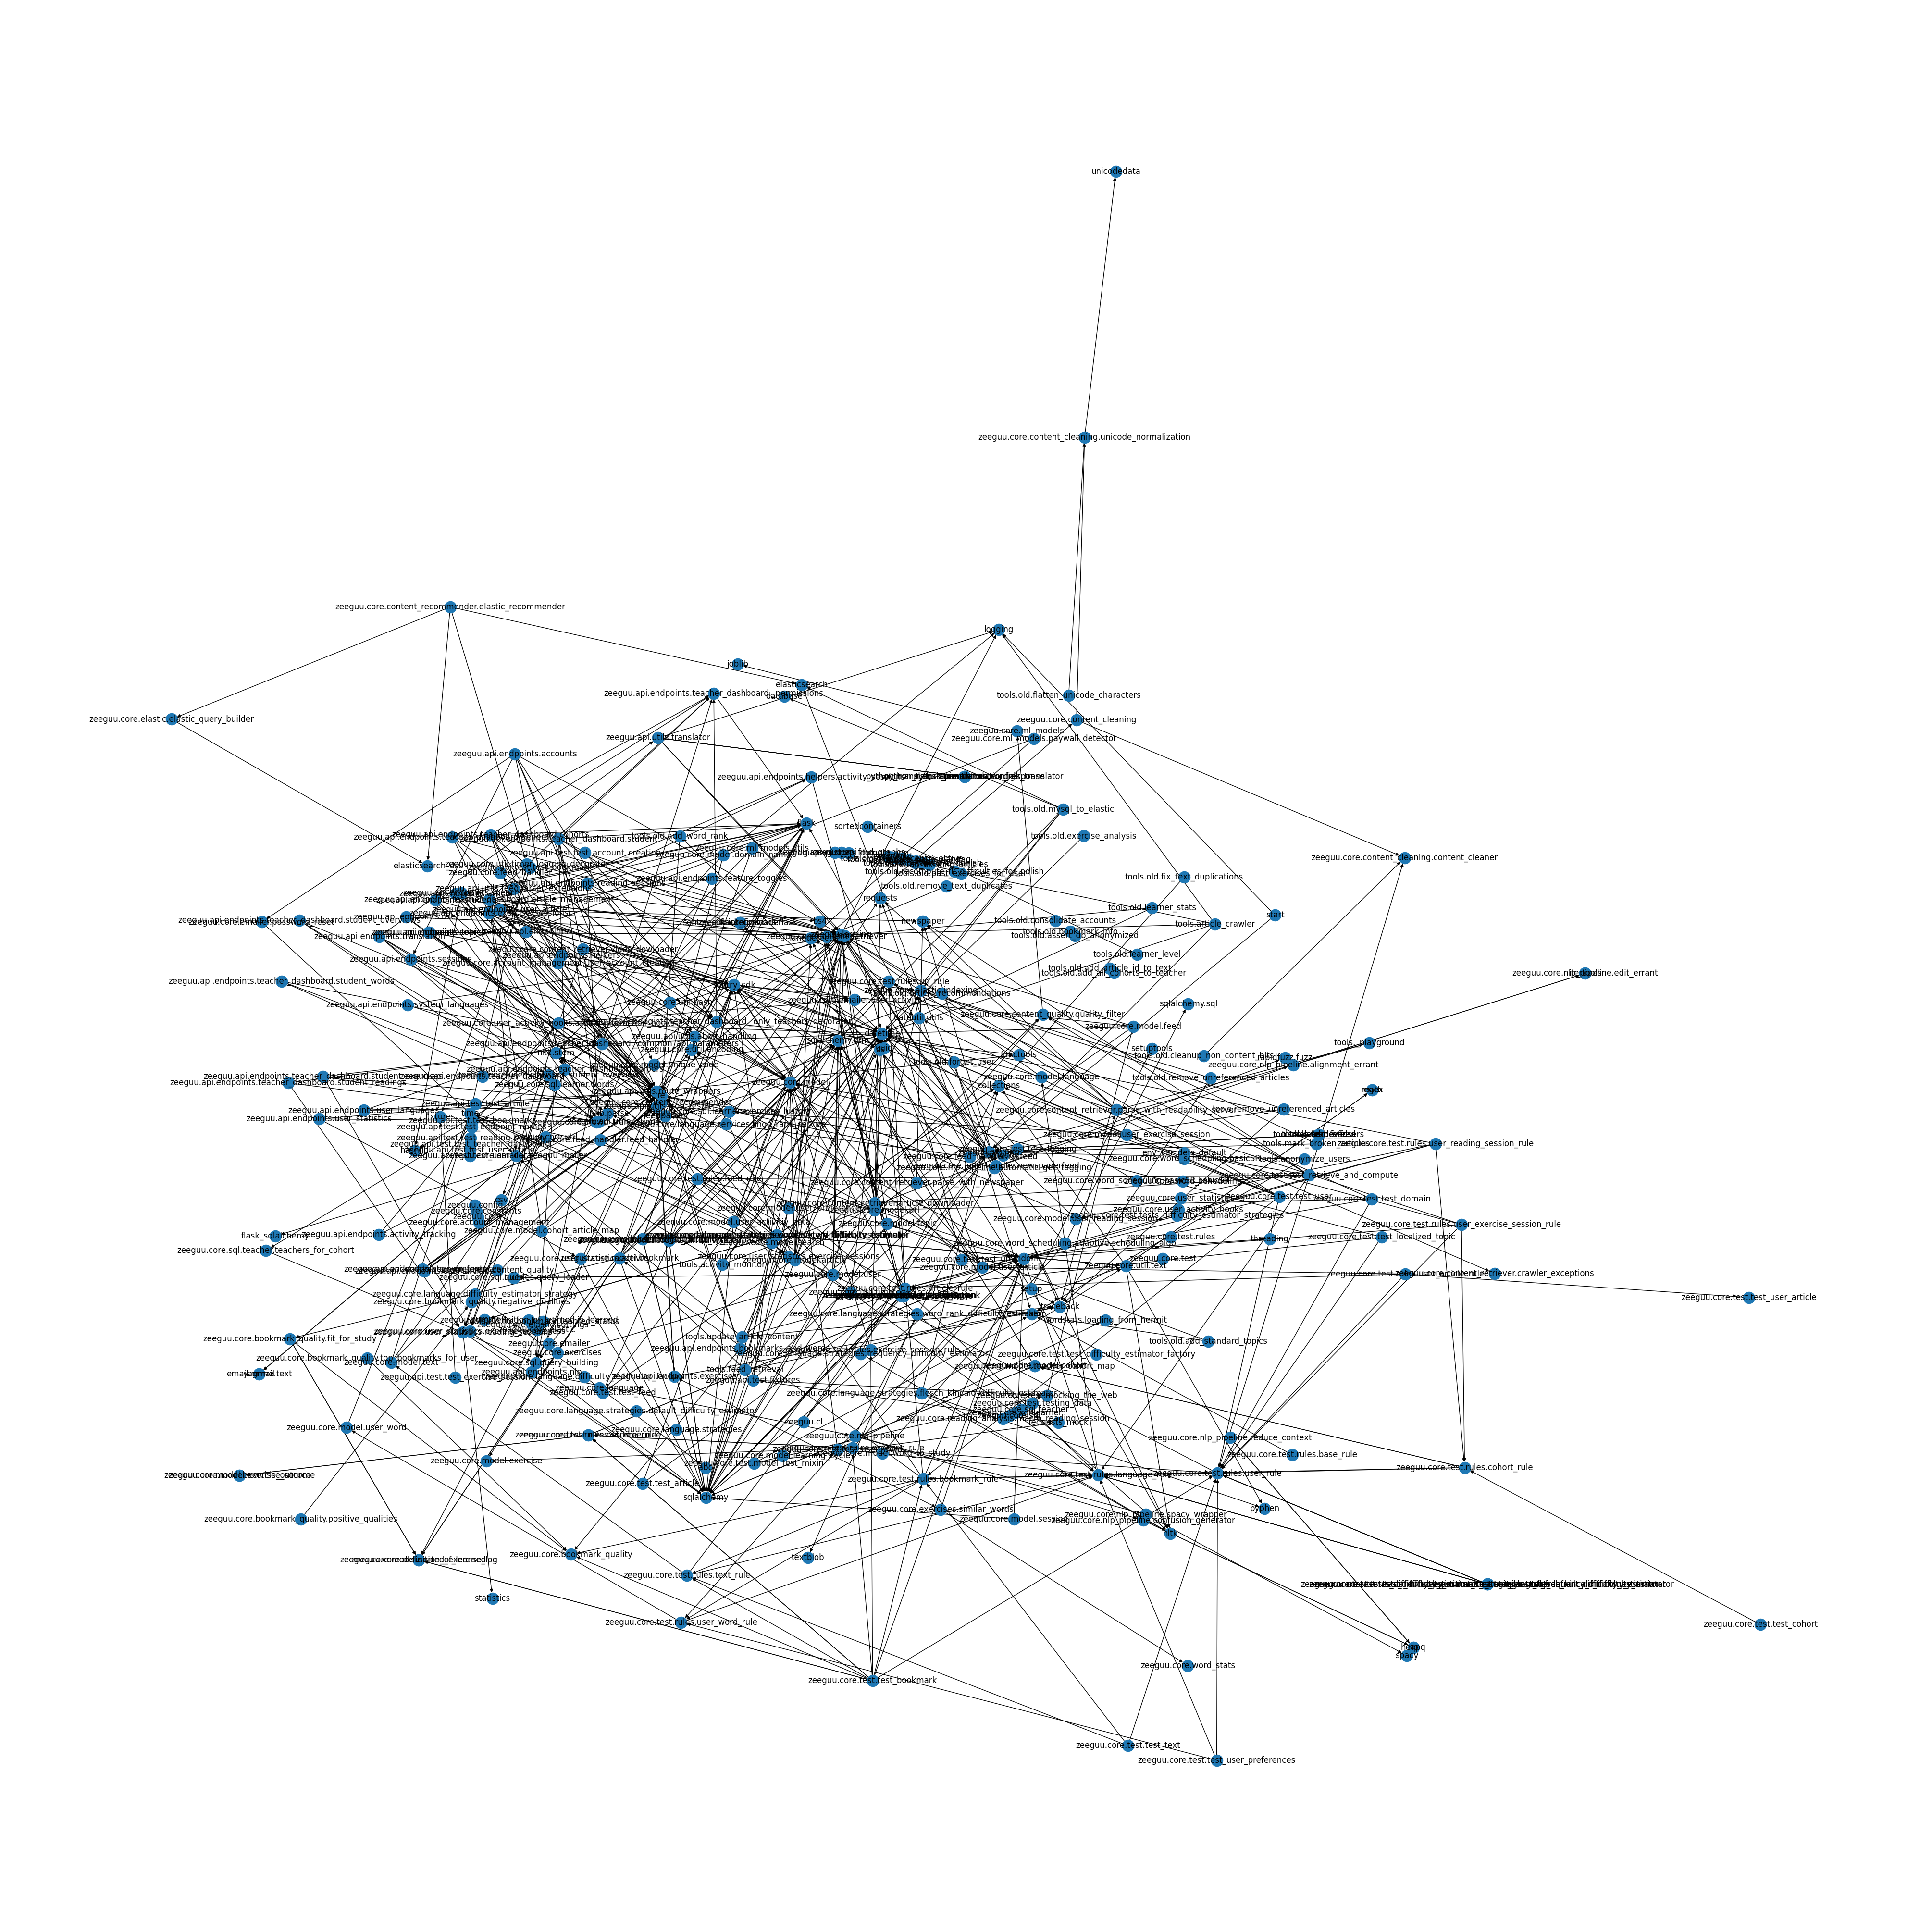

In [9]:
DG = nx_dependencies_digraph(CODE_ROOT_FOLDER)
draw_graph(DG, (40,40), with_labels=True)

In [10]:
#Remove irrelevant modules
def relevant_module(module_name):
    if "test" in module_name:
        return False

    if "util" in module_name:
        return False

    if "config" in module_name:
        return False
    
    if "tool" in module_name:
        return False

    #if "core" in module_name:
        #return False
    
    if module_name.startswith("zeeguu"):
        return True
    
    return False

In [11]:
# New Directed Graph for relevant modules
def nx_dependencies_digraph_relevant(code_root_folder, show_unused_dependencies=False):
    G = nx.DiGraph()
    all_files = get_all_files_in_repo(code_root_folder)
    all_dependencies, all_unused_dependencies, all_used_dependencies = collect_all_dependencies()
    
    for file in all_files:
        module_name = module_name_from_file_path(file)
        if relevant_module(module_name):
            #Add a note for the module/file if not present
            if module_name not in G.nodes:
                G.add_node(module_name)
            if show_unused_dependencies:
                for each in all_dependencies[module_name]:
                    if(relevant_module(each)):
                        G.add_edge(module_name, each)
            else:
                #Add an edge for each used dependency
                #if the dependency is relevant
                for each in all_used_dependencies[module_name]:
                    if(relevant_module(each)):
                        G.add_edge(module_name, each)
                #The reason there is so many nodes with no edges is because the used dependencies are not in the relevant modules
                #But still weird there is no edges to them? Nah, they are probably importated as well, but not used in the code anymore? has to be the case
                # So it is a file, with no relevant dependencies that are not used anywhere else?
    return G

C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\language\strategies\word_rank_difficulty_estimator.py:63: SyntaxWarning: invalid escape sequence '\d'
  words = [w for w in words if re.search("\d", w) == None]
C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\model\article.py:28: SyntaxWarning: invalid escape sequence '\s'
  MULTIPLE_NEWLINES = re.compile("\n\s*\n")
C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\model\starred_article.py:71: SyntaxWarning: invalid escape sequence '\ '
  """


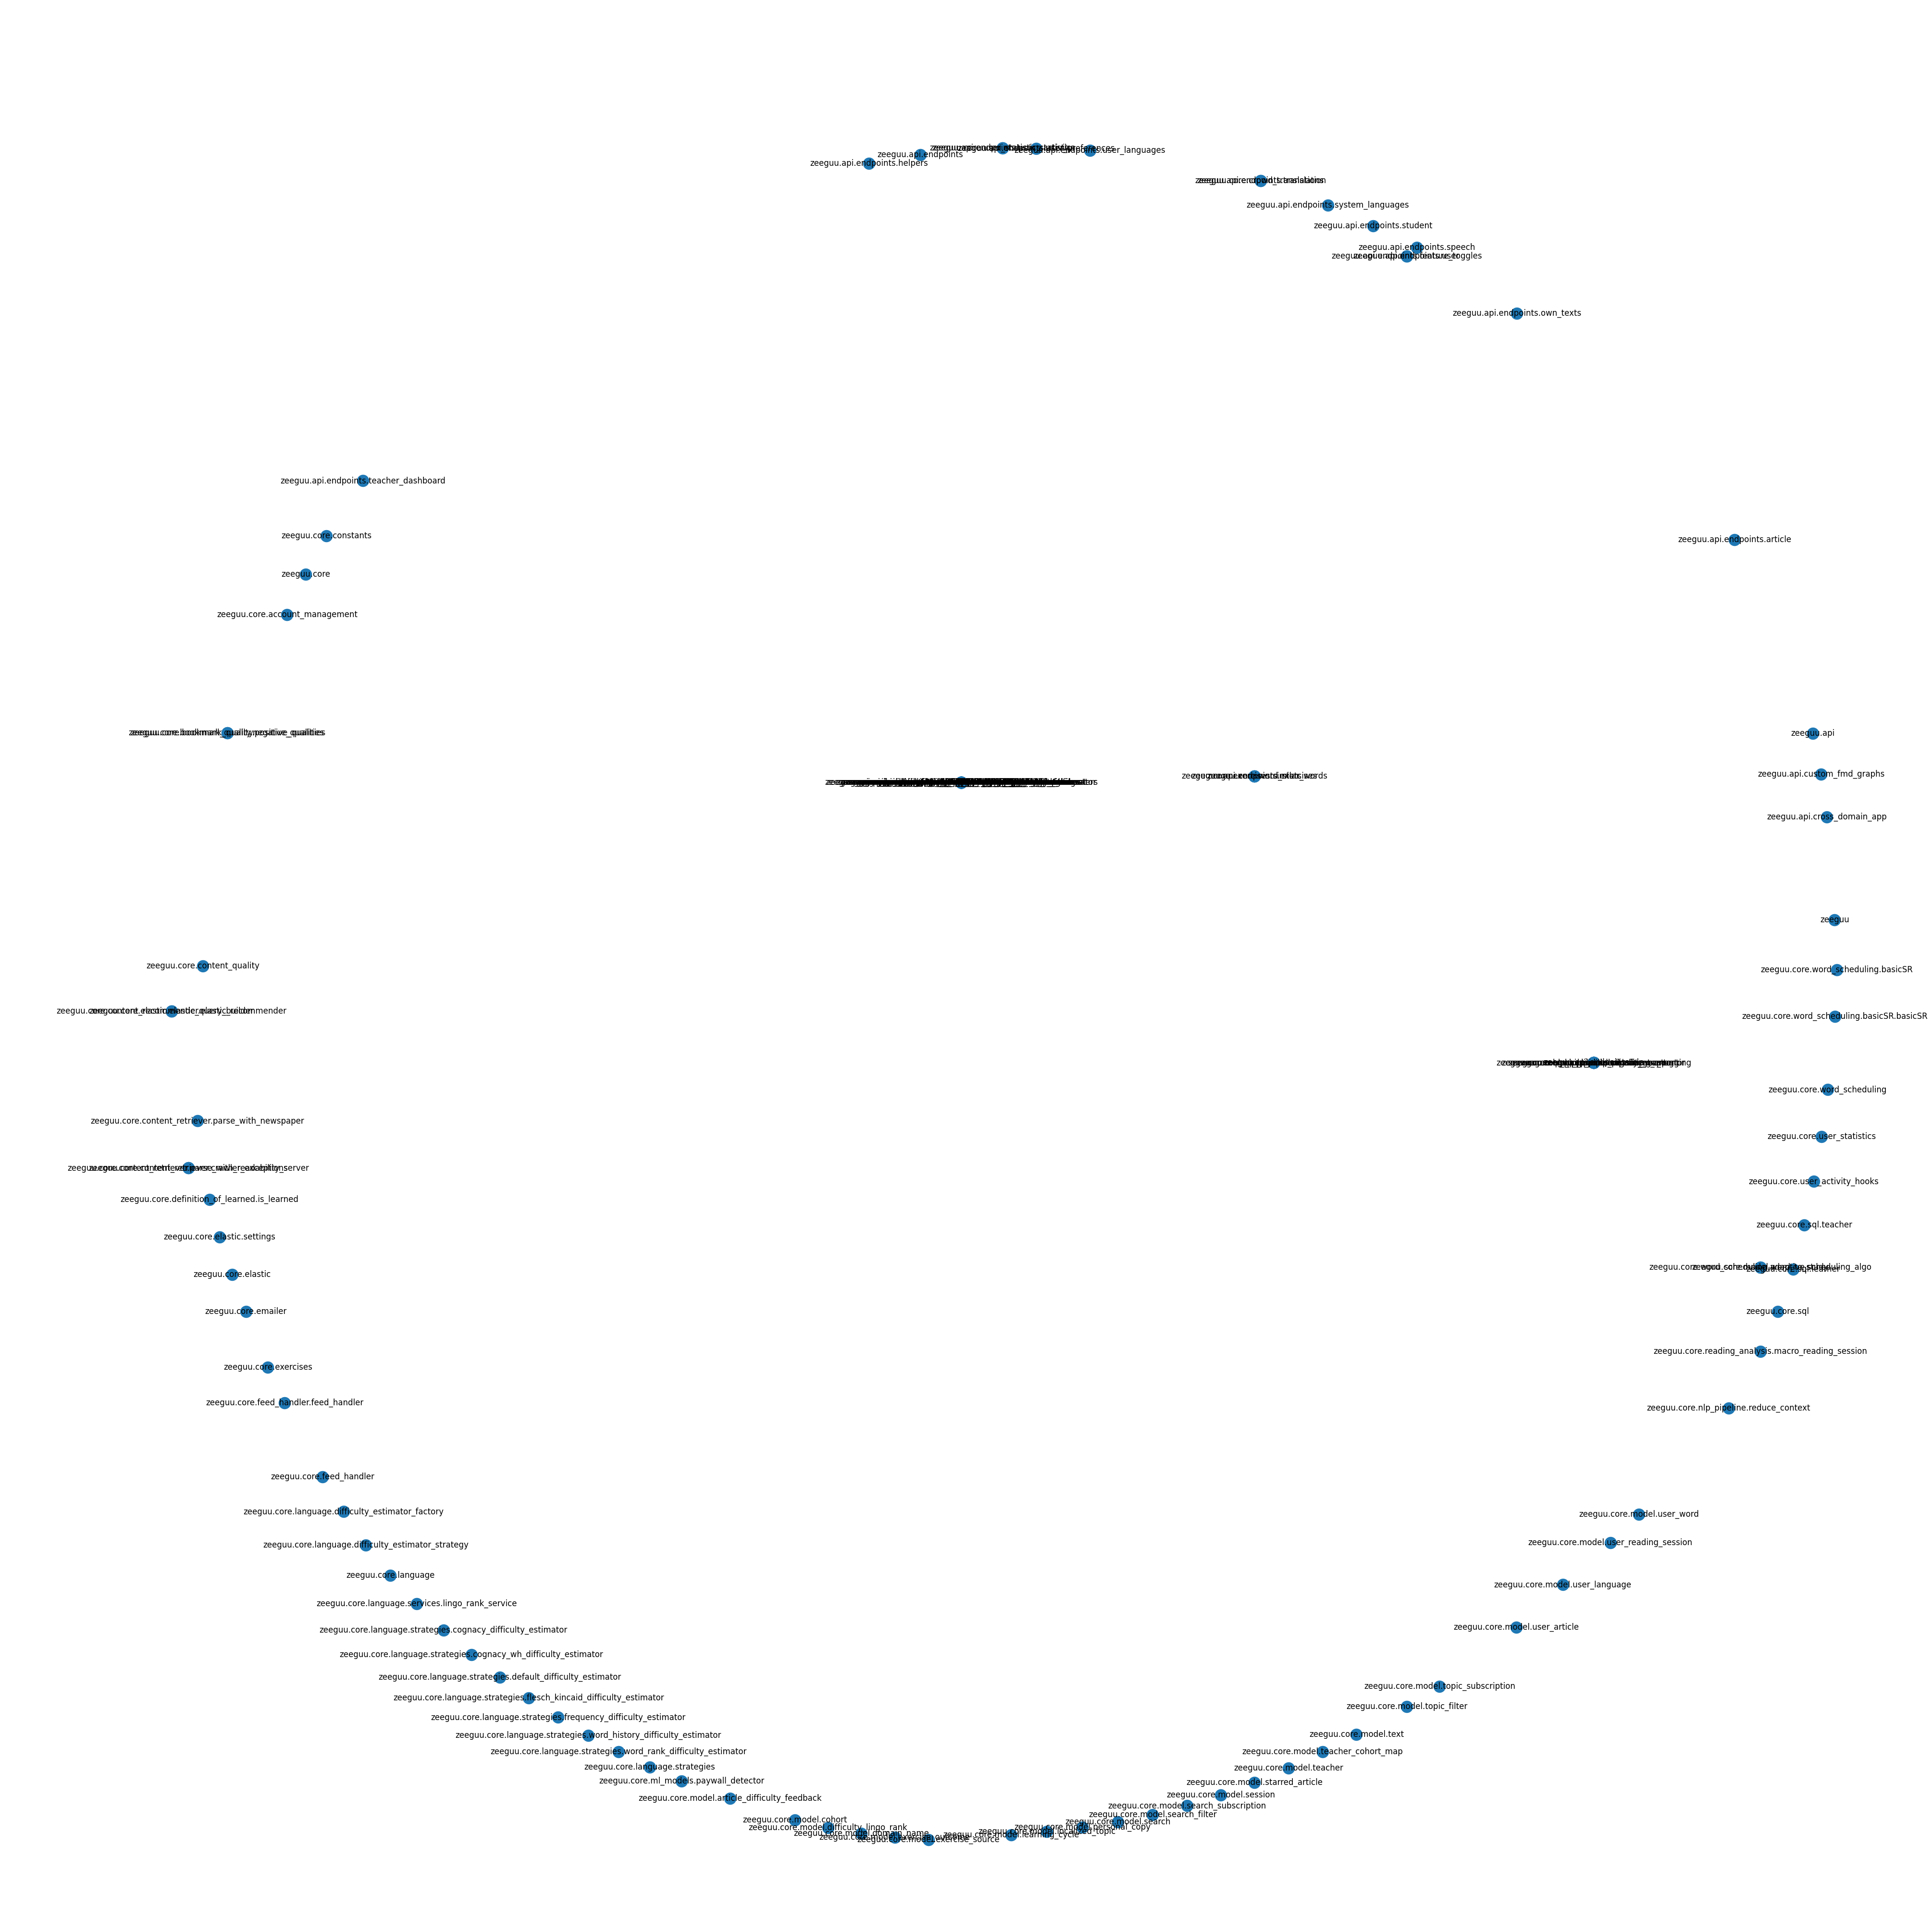

Length of nodes:  167
amount of edges:  114


In [12]:
#Draw DIGRAPH for relevant modules
DG = nx_dependencies_digraph_relevant(CODE_ROOT_FOLDER, False)
draw_graph(DG, (40,40), with_labels=True)
#print length of nodes list in graph
print("Length of nodes: ", len(DG.nodes))
print("amount of edges: ", len(DG.edges))

In [14]:
#Abstract to top-level modules and remove cycles
def top_level_package(module_name, depth):
    #print(module_name)
    components = module_name.split(".")
    return ".".join(components[:depth])

def abstracted_to_top_level(G, depth):
    aG = nx.DiGraph()
    for each in G.edges():
        src = top_level_package(each[0], depth)
        dst = top_level_package(each[1], depth)

        if src != dst:
          aG.add_edge(src, dst)

    return aG


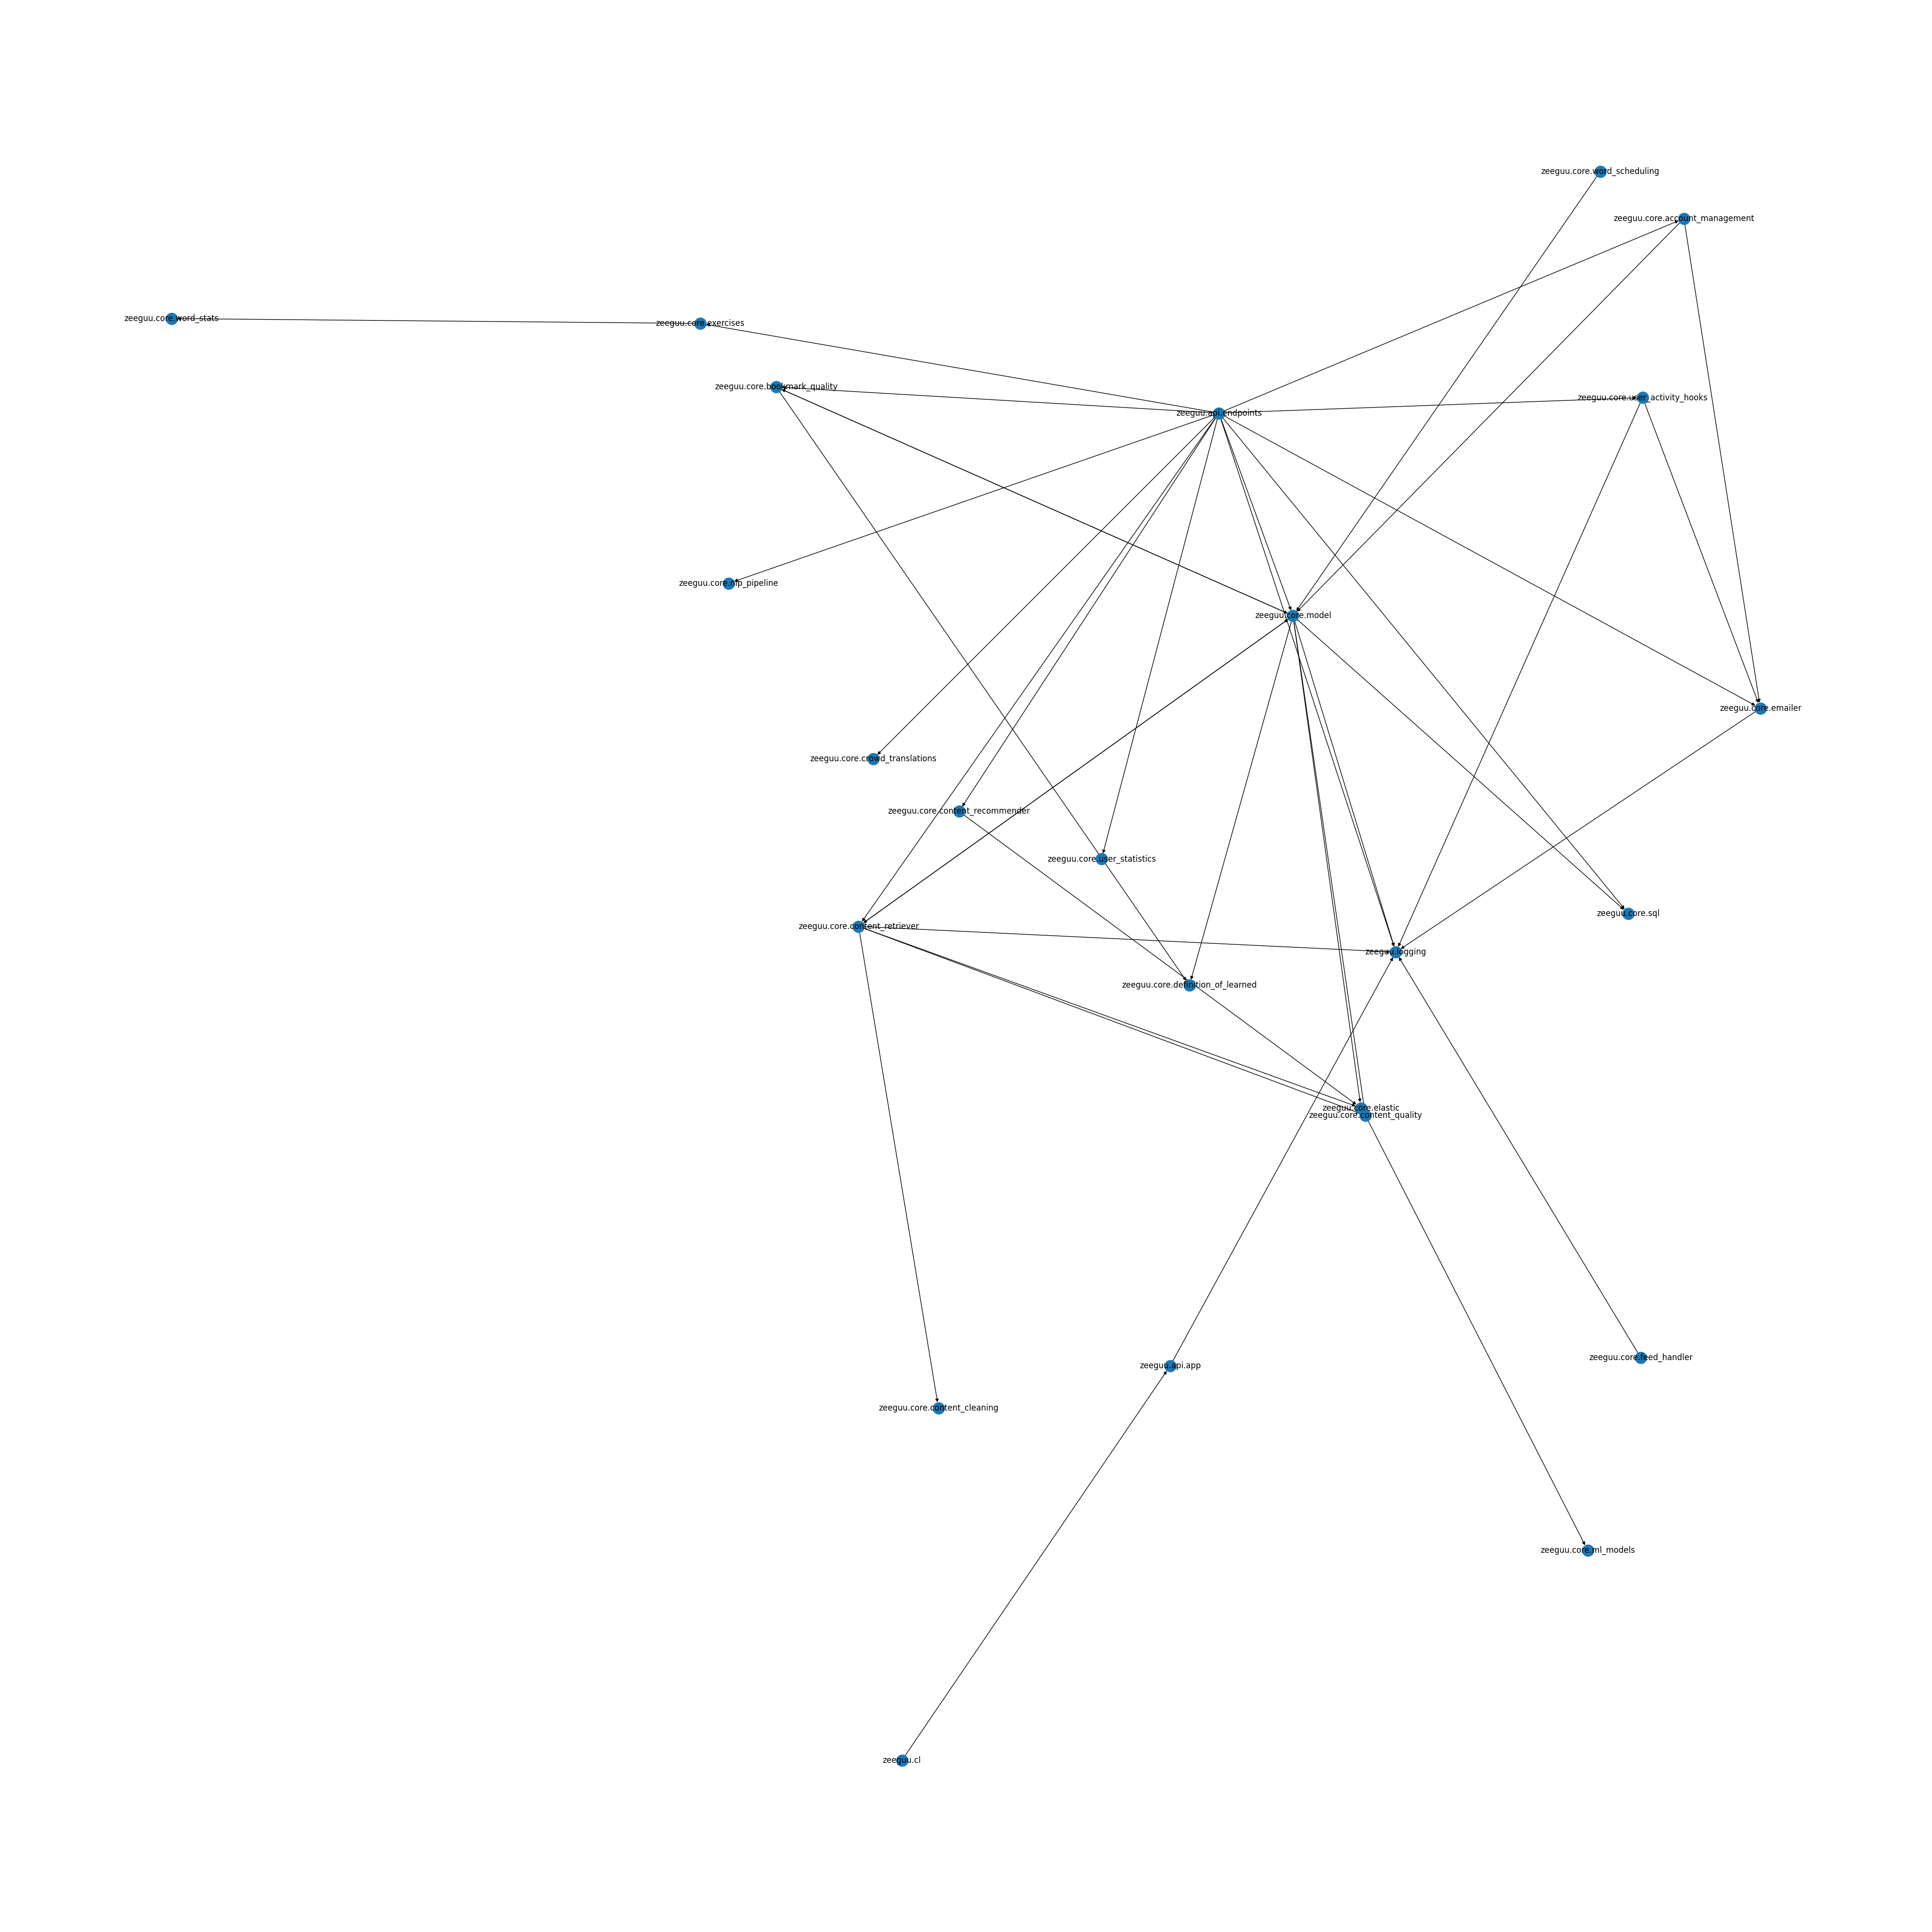

In [15]:
#Draw DIGRAPH for relevant modules with top-level
DG = abstracted_to_top_level(DG, 3)
draw_graph(DG, (40,40), with_labels=True)

In [29]:
#draw pyvis graph
from pyvis.network import Network
import networkx as nx
from IPython.display import HTML, display

def draw_pyvis_graph(G):
    nt = Network(height="100%", width="100%", notebook=True, cdn_resources='in_line', directed=True)
    nt.from_nx(G)
    nt.toggle_physics(True)
    nt.save_graph("nx_pyv.html")
    nt.show("nx_pyv.html")
    #with open("nx_pyv.html", "r") as f:
        #display(HTML(f.read()))
    
    
#now draw from the abstracted graph
DG = nx_dependencies_digraph_relevant(CODE_ROOT_FOLDER, False)
DG = abstracted_to_top_level(DG, 3)
draw_pyvis_graph(DG)



C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\language\strategies\word_rank_difficulty_estimator.py:63: SyntaxWarning: invalid escape sequence '\d'
  words = [w for w in words if re.search("\d", w) == None]
C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\model\article.py:28: SyntaxWarning: invalid escape sequence '\s'
  MULTIPLE_NEWLINES = re.compile("\n\s*\n")
C:/Users/carl9/OneDrive/Skrivebord/SA_Individual_ZeeguuAPI/reconstruction/zeeguu-api/zeeguu\core\model\starred_article.py:71: SyntaxWarning: invalid escape sequence '\ '
  """


nx_pyv.html
